# Computing image gradients in PyTorch by Thomas Poulet (thomas.poulet@csiro.au)

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
pi = np.pi

## Using a 3x3 filter (not computing derivative on boundary layers)
(https://en.wikipedia.org/wiki/Image_derivative or
http://www.k-zone.nl/Kroon_DerivativePaper.pdf)
$f(x,y)=cos(2\pi x) sin(2\pi y)$


xvals.shape= torch.Size([64])
yvals.shape= torch.Size([64])
img_dy0.shape = torch.Size([1, 1, 62, 62]), ana_dx.shape = torch.Size([64, 64])
torch.max(img_dx0)= tensor(1.1102)
torch.max(ana_dx cropped) = tensor(6.2793)
Real coeff_x =  5.655785083770752
Real coeff_y =  5.655785083770752
Real alpha_x =  0.08977437019348145
Real alpha_y =  0.08977437019348145
From formula, alpha_x =  0.08960791712625849
From formula, alpha_y =  0.08960791712625849
coeff_x = -5.645298778954285, coeff_y = -5.645298778954285
shape img_dx =  torch.Size([1, 1, 62, 62])
Max value of img_dx is 6.267637729644775
Max value of ana_dx (cropped) is 6.279280185699463


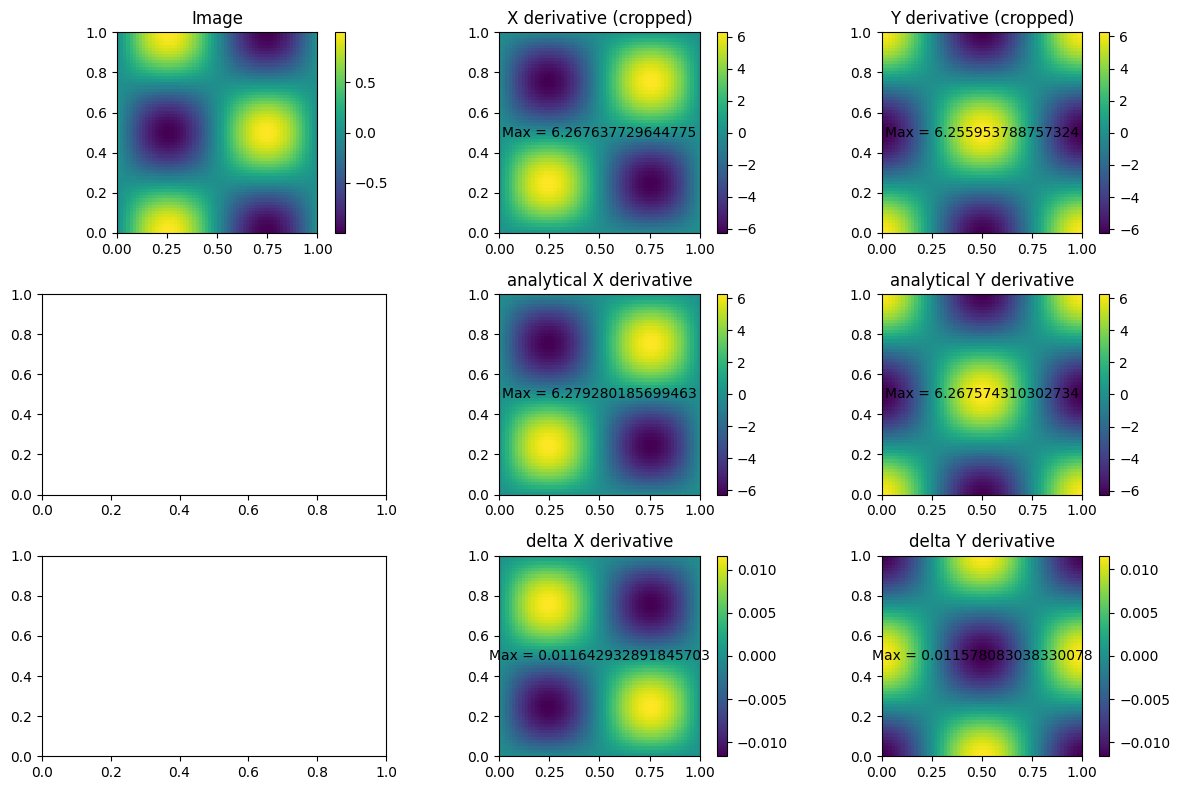

In [ ]:
nx = 64; xmin=0.; xmax=1.0; delta_x = (xmax-xmin)/(nx-1)
xvals = torch.arange(start=xmin, end=xmax+1e-6, step=delta_x)
ny = 64; ymin=0.; ymax=1.0; delta_y = (ymax-ymin)/(ny-1)
yvals = torch.arange(start=ymin, end=ymax+1e-6, step=delta_y)
print('xvals.shape=',xvals.shape)
print('yvals.shape=',xvals.shape)

# Filter kernels
k = torch.Tensor([1., 3.5887, 1.]); # or [3., 10., 3.] or [17., 61., 17.]
d = torch.Tensor([1., 0., -1.]);
gy = torch.outer(k, d)
gx = gy.transpose(0,1)
# print('gx={0}'.format(gx))

# Image tensor
img = torch.outer(torch.cos(2*pi*xvals), torch.sin(2*pi*yvals))
img = img.reshape(1, 1, nx, ny)
ana_dx = -2*pi*torch.outer(torch.sin(2*pi*xvals), torch.sin(2*pi*yvals)) # analytical sol
ana_dy =  2*pi*torch.outer(torch.cos(2*pi*xvals), torch.cos(2*pi*yvals)) # analytical sol
ana_dx.reshape(1, 1, nx, ny)
ana_dy.reshape(1, 1, nx, ny)

# Find mutliplying coefficient to get exact derivatives
img_dx0 = -F.conv2d(img, gx.view(1, 1, 3, 3))
img_dy0 = -F.conv2d(img, gy.view(1, 1, 3, 3))
print('img_dy0.shape = {0}, ana_dx.shape = {1}'.format(img_dy0.shape, ana_dx.shape))
print('torch.max(img_dx0)=',torch.max(img_dx0))
print('torch.max(ana_dx cropped) =',torch.max(ana_dx[1:-1, 1:-1]))
real_coeff_x = torch.max(ana_dx[1:-1, 1:-1]) / torch.max(img_dx0)
real_coeff_y = torch.max(ana_dy[1:-1, 1:-1]) / torch.max(img_dy0)
print('Real coeff_x = ', real_coeff_x.item())
print('Real coeff_y = ', real_coeff_y.item())
alpha_x = real_coeff_x * delta_x
alpha_y = real_coeff_y * delta_y
print('Real alpha_x = ', alpha_x.item())
print('Real alpha_y = ', alpha_y.item())

# Using alpha from empirically found law (see "Image_gradient_coeff_3x3.xlsx")
if 1:
  alpha_x = (0.0950787365436554-0.0895532116680106)*np.exp(-0.0961493756747349*(nx-16))+0.0895532116680106
  alpha_y = (0.0950787365436554-0.0895532116680106)*np.exp(-0.0961493756747349*(ny-16))+0.0895532116680106
  print('From formula, alpha_x = ', alpha_x.item())
  print('From formula, alpha_y = ', alpha_y.item())
coeff_x = -alpha_x / delta_x
coeff_y = -alpha_y / delta_y
print("coeff_x = {0}, coeff_y = {1}".format(coeff_x, coeff_y))

# Convolve image
img_dx = coeff_x * F.conv2d(img, gx.view(1, 1, 3, 3))
img_dy = coeff_y * F.conv2d(img, gy.view(1, 1, 3, 3))
print('shape img_dx = ', img_dx.shape)

# # Calculate gradient magnitude
# magnitude = torch.sqrt(img_dx**2 + img_dy**2)

# # Calculate gradient orientation
# orientation = torch.atan2(img_dy, img_dx)

# plot
print('Max value of img_dx is {0}'.format(torch.max(img_dx)))
print('Max value of ana_dx (cropped) is {0}'.format(torch.max(ana_dx[1:-1, 1:-1])))
fig, ((ax1, ax2, ax3), (_, ax5, ax6), (_, ax8, ax9)) = plt.subplots(3, 3, figsize=(12, 8))
s1 = ax1.imshow(img[0,0,:,:], extent=[xmin,xmax,ymin,ymax])
fig.colorbar(s1, ax=ax1)
ax1.set_title("Image")

s2 = ax2.imshow(img_dx[0,0,:,:], extent=[xmin,xmax,ymin,ymax])
fig.colorbar(s2, ax=ax2)
ax2.set_title("X derivative (cropped)")
ax2.text(0.5, 0.5, 'Max = {0}'.format(torch.max(img_dx)), ha='center', va='center')

s3 = ax3.imshow(img_dy[0,0,:,:], extent=[xmin,xmax,ymin,ymax])
fig.colorbar(s3, ax=ax3)
ax3.set_title("Y derivative (cropped)")
ax3.text(0.5, 0.5, 'Max = {0}'.format(torch.max(img_dy)), ha='center', va='center')

s5 = ax5.imshow(ana_dx[1:-1,1:-1], extent=[xmin,xmax,ymin,ymax])
fig.colorbar(s5, ax=ax5)
ax5.set_title("analytical X derivative")
ax5.text(0.5, 0.5, 'Max = {0}'.format(torch.max(ana_dx[1:-1,1:-1])), ha='center', va='center')

s6 = ax6.imshow(ana_dy[1:-1,1:-1], extent=[xmin,xmax,ymin,ymax])
fig.colorbar(s6, ax=ax6)
ax6.set_title("analytical Y derivative")
ax6.text(0.5, 0.5, 'Max = {0}'.format(torch.max(ana_dy[1:-1,1:-1])), ha='center', va='center')

s8 = ax8.imshow(img_dx[0,0,:,:] - ana_dx[1:-1,1:-1], extent=[xmin,xmax,ymin,ymax])
fig.colorbar(s8, ax=ax8)
ax8.set_title("delta X derivative")
ax8.text(0.5, 0.5, 'Max = {0}'.format(torch.max(img_dx[0,0,:,:] - ana_dx[1:-1,1:-1])), ha='center', va='center')

s9 = ax9.imshow(img_dy[0,0,:,:] - ana_dy[1:-1,1:-1], extent=[xmin,xmax,ymin,ymax])
fig.colorbar(s9, ax=ax9)
ax9.set_title("delta Y derivative")
ax9.text(0.5, 0.5, 'Max = {0}'.format(torch.max(img_dy[0,0,:,:] - ana_dy[1:-1,1:-1])), ha='center', va='center')

fig.tight_layout()
plt.show()


## Using a 3x3 filter (trying to compute derivative on boundary layers)

xvals.shape= torch.Size([32])
yvals.shape= torch.Size([32])
img_dy0.shape = torch.Size([1, 1, 30, 30]), ana_dx.shape = torch.Size([32, 32])
torch.max(img_dx0)= tensor(2.2278)
torch.max(ana_dx cropped) = tensor(6.2671)
Real coeff_x =  2.8131425380706787
Real coeff_y =  2.813141345977783
Real alpha_x =  0.09074652940034866
Real alpha_y =  0.09074649214744568
coeff_x = -2.8131425380706787, coeff_y = -2.813141345977783
shape img_padded =  torch.Size([1, 1, 34, 34])


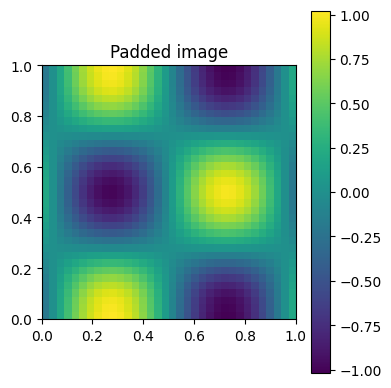

shape img_dx =  torch.Size([1, 1, 32, 32])
Max value of img_dx is 6.2670674324035645
Max value of ana_dx (cropped) is 6.2670674324035645


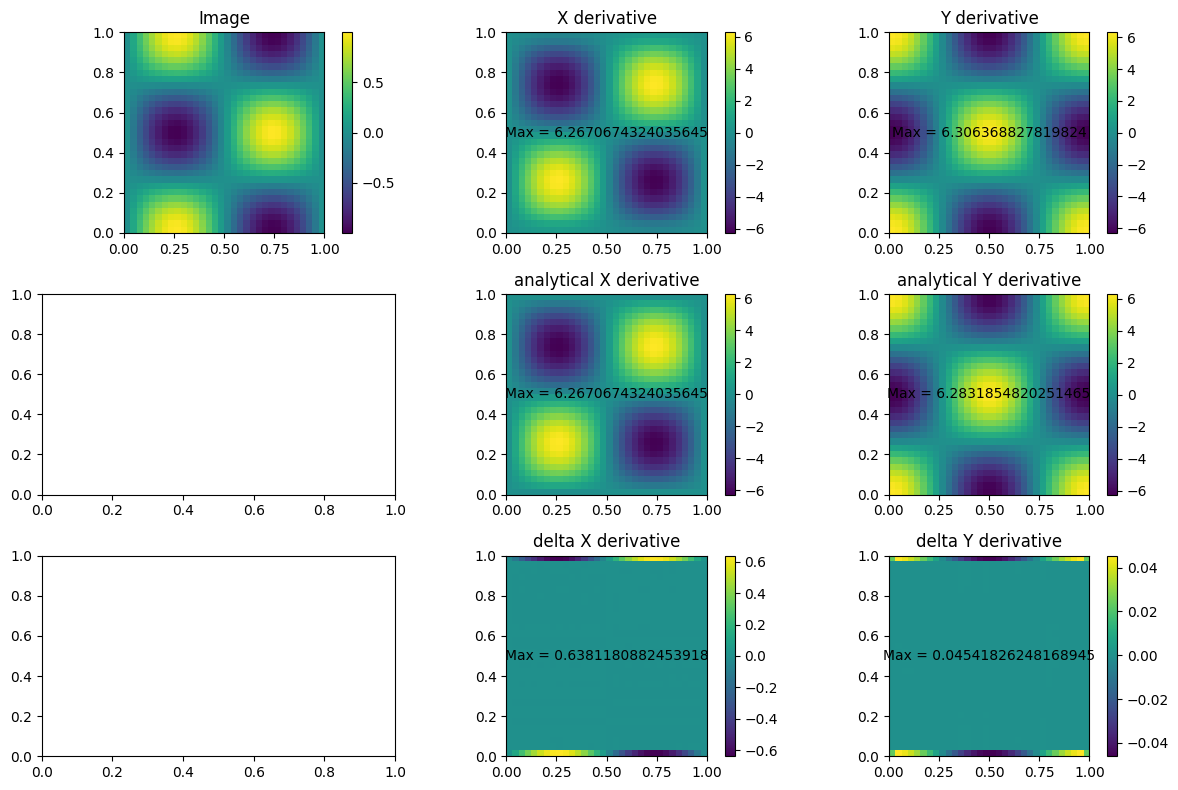

In [ ]:
nx = 32; xmin=0.; xmax=1.0; delta_x = (xmax-xmin)/(nx-1)
xvals = torch.arange(start=xmin, end=xmax+1e-6, step=delta_x)
ny = 32; ymin=0.; ymax=1.0; delta_y = (ymax-ymin)/(ny-1)
yvals = torch.arange(start=ymin, end=ymax+1e-6, step=delta_y)
print('xvals.shape=',xvals.shape)
print('yvals.shape=',xvals.shape)

# Filter kernels
k = torch.Tensor([1., 3.5887, 1.]); # or [3., 10., 3.] or [17., 61., 17.]
d = torch.Tensor([1., 0., -1.]);
gy = torch.outer(k, d)
gx = gy.transpose(0,1)
# print('gx={0}'.format(gx))

# Image tensor
img = torch.outer(torch.cos(2*pi*xvals), torch.sin(2*pi*yvals))
img = img.reshape(1, 1, nx, ny)
ana_dx = -2*pi*torch.outer(torch.sin(2*pi*xvals), torch.sin(2*pi*yvals)) # analytical sol
ana_dy =  2*pi*torch.outer(torch.cos(2*pi*xvals), torch.cos(2*pi*yvals)) # analytical sol
ana_dx.reshape(1, 1, nx, ny)
ana_dy.reshape(1, 1, nx, ny)

# Find mutliplying coefficient to get exact derivatives
img_dx0 = -F.conv2d(img, gx.view(1, 1, 3, 3))
img_dy0 = -F.conv2d(img, gy.view(1, 1, 3, 3))
print('img_dy0.shape = {0}, ana_dx.shape = {1}'.format(img_dy0.shape, ana_dx.shape))
print('torch.max(img_dx0)=',torch.max(img_dx0))
print('torch.max(ana_dx cropped) =',torch.max(ana_dx[1:-1, 1:-1]))
real_coeff_x = torch.max(ana_dx[1:-1, 1:-1]) / torch.max(img_dx0)
real_coeff_y = torch.max(ana_dy[1:-1, 1:-1]) / torch.max(img_dy0)
print('Real coeff_x = ', real_coeff_x.item())
print('Real coeff_y = ', real_coeff_y.item())
alpha_x = real_coeff_x * delta_x
alpha_y = real_coeff_y * delta_y
print('Real alpha_x = ', alpha_x.item())
print('Real alpha_y = ', alpha_y.item())

# Using alpha from empirically found law (see "Image_gradient_coeff_3x3.xlsx")
if 0:
  alpha_x = (0.0950787365436554-0.0895532116680106)*np.exp(-0.0961493756747349*(nx-16))+0.0895532116680106
  alpha_y = (0.0950787365436554-0.0895532116680106)*np.exp(-0.0961493756747349*(ny-16))+0.0895532116680106
  print('From formula, alpha_x = ', alpha_x.item())
  print('From formula, alpha_y = ', alpha_y.item())
coeff_x = -alpha_x / delta_x
coeff_y = -alpha_y / delta_y
print("coeff_x = {0}, coeff_y = {1}".format(coeff_x, coeff_y))

# Use own padding, since the "padding='same'" option is not satisfying
img_padded = torch.empty(1, 1, nx+2, ny+2)
img_padded[0, 0, 1:-1, 1:-1] = img

img_padded[0, 0, 0, 1:-1] = 2*img[0, 0, 0, :] - img[0, 0, 1, :] # top edge
img_padded[0, 0, -1, 1:-1] = 2*img[0, 0, -1, :] - img[0, 0, -2, :] # bottom edge
img_padded[0, 0, 1:-1, 0] = 2*img[0, 0, :, 0] - img[0, 0, :, 1] # left edge
img_padded[0, 0, 1:-1, -1] = 2*img[0, 0, :, -1] - img[0, 0, :, -2] # right edge

img_padded[0, 0, 0, 0] = 2*img[0, 0, 0, 0] - img[0, 0, 1, 1] # top left corner
img_padded[0, 0, -1, 0] = 2*img[0, 0, -1, 0] - img[0, 0, -2, 1] # bottom left corner
img_padded[0, 0, 0, -1] = 2*img[0, 0, 0, -1] - img[0, 0, 1, -2] # top right corner
img_padded[0, 0, -1, -1] = 2*img[0, 0, -1, -1] - img[0, 0, -2, -2] # bottom right corner
print('shape img_padded = ', img_padded.shape)
if 1:
  fig, ax1 = plt.subplots(1, 1, figsize=(4, 4))
  s1 = ax1.imshow(img_padded[0,0,:,:], extent=[xmin,xmax,ymin,ymax])
  fig.colorbar(s1, ax=ax1)
  ax1.set_title("Padded image")
  fig.tight_layout()
  plt.show()

# Convolve image
# img_dx = coeff_x * F.conv2d(img, gx.view(1, 1, 3, 3), padding='same')
# img_dy = coeff_y * F.conv2d(img, gy.view(1, 1, 3, 3), padding='same')
img_dx = coeff_x * F.conv2d(img_padded, gx.view(1, 1, 3, 3))
img_dy = coeff_y * F.conv2d(img_padded, gy.view(1, 1, 3, 3))
print('shape img_dx = ', img_dx.shape)

# # Calculate gradient magnitude
# magnitude = torch.sqrt(img_dx**2 + img_dy**2)

# # Calculate gradient orientation
# orientation = torch.atan2(img_dy, img_dx)

# plot
if 1:
  print('Max value of img_dx is {0}'.format(torch.max(img_dx)))
  print('Max value of ana_dx (cropped) is {0}'.format(torch.max(ana_dx[1:-1, 1:-1])))
  fig, ((ax1, ax2, ax3), (_, ax5, ax6), (_, ax8, ax9)) = plt.subplots(3, 3, figsize=(12, 8))
  s1 = ax1.imshow(img[0,0,:,:], extent=[xmin,xmax,ymin,ymax])
  fig.colorbar(s1, ax=ax1)
  ax1.set_title("Image")

  s2 = ax2.imshow(img_dx[0,0,:,:], extent=[xmin,xmax,ymin,ymax])
  fig.colorbar(s2, ax=ax2)
  ax2.set_title("X derivative")
  ax2.text(0.5, 0.5, 'Max = {0}'.format(torch.max(img_dx)), ha='center', va='center')

  s3 = ax3.imshow(img_dy[0,0,:,:], extent=[xmin,xmax,ymin,ymax])
  fig.colorbar(s3, ax=ax3)
  ax3.set_title("Y derivative")
  ax3.text(0.5, 0.5, 'Max = {0}'.format(torch.max(img_dy)), ha='center', va='center')

  s5 = ax5.imshow(ana_dx, extent=[xmin,xmax,ymin,ymax])
  fig.colorbar(s5, ax=ax5)
  ax5.set_title("analytical X derivative")
  ax5.text(0.5, 0.5, 'Max = {0}'.format(torch.max(ana_dx)), ha='center', va='center')

  s6 = ax6.imshow(ana_dy, extent=[xmin,xmax,ymin,ymax])
  fig.colorbar(s6, ax=ax6)
  ax6.set_title("analytical Y derivative")
  ax6.text(0.5, 0.5, 'Max = {0}'.format(torch.max(ana_dy)), ha='center', va='center')

  s8 = ax8.imshow(img_dx[0,0,:,:] - ana_dx, extent=[xmin,xmax,ymin,ymax])
  fig.colorbar(s8, ax=ax8)
  ax8.set_title("delta X derivative")
  ax8.text(0.5, 0.5, 'Max = {0}'.format(torch.max(img_dx - ana_dx)), ha='center', va='center')

  s9 = ax9.imshow(img_dy[0,0,:,:] - ana_dy, extent=[xmin,xmax,ymin,ymax])
  fig.colorbar(s9, ax=ax9)
  ax9.set_title("delta Y derivative")
  ax9.text(0.5, 0.5, 'Max = {0}'.format(torch.max(img_dy - ana_dy)), ha='center', va='center')

  fig.tight_layout()
  plt.show()


## Using a 5x5 filter
(https://en.wikipedia.org/wiki/Image_derivative or
http://www.k-zone.nl/Kroon_DerivativePaper.pdf)

## using function
$f(x,y)=cos(2\pi x) sin(2\pi y)$
to identify alpha(n) empirical formula (but not for small values of n)

delta_x= 0.015873015873015872
delta_y= 0.015873015873015872
img_dy0.shape = torch.Size([1, 1, 60, 60]), ana_dx.shape = torch.Size([64, 64])
torch.max(img_dx0)= tensor(0.0992)
torch.max(ana_dx cropped) = tensor(6.2793)
Real coeff_x =  63.29038619995117
Real coeff_y =  63.290374755859375
Real alpha_x =  1.0046093463897705
Real alpha_y =  1.004609227180481
From formula, alpha_x =  1.000538612223744
From formula, alpha_y =  1.000538612223744
coeff_x = -63.03393257009588, coeff_y = -63.03393257009588
shape img_dx =  torch.Size([1, 1, 60, 60])
Max value of img_dx is 6.253836631774902
Max value of ana_dx (cropped) is 6.279280185699463


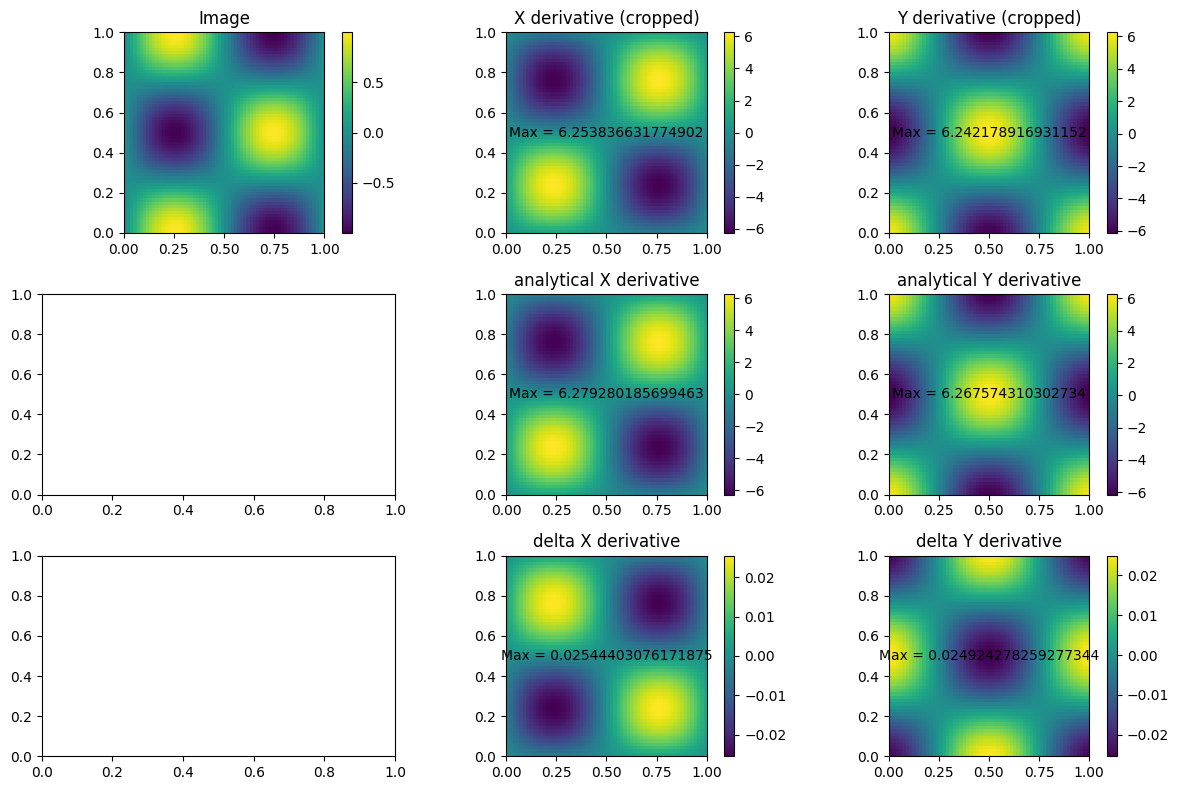

In [ ]:
nx = 64; xmin=0.; xmax=1.0; delta_x = (xmax-xmin)/(nx-1)
xvals = torch.arange(start=xmin, end=xmax+1e-6, step=delta_x)
ny = 64; ymin=0.; ymax=1.0; delta_y = (ymax-ymin)/(ny-1)
yvals = torch.arange(start=ymin, end=ymax+1e-6, step=delta_y)
print('delta_x=',delta_x)
print('delta_y=',delta_y)

# Filter kernels
k = torch.Tensor([0.030320,  0.249724,  0.439911,  0.249724,  0.030320]);
d = torch.Tensor([0.104550,  0.292315,  0.000000, -0.292315, -0.104550]);
gy = torch.outer(k, d)
gx = gy.transpose(0,1)
# print('gx={0}'.format(gx))
# print('gy={0}'.format(gy))
# print('gx*gy={0}'.format(gx*gy))

# Image tensor (random analytical function so we can take its derivatives)
img = torch.outer(torch.cos(2*pi*xvals), torch.sin(2*pi*yvals))
img = img.reshape(1, 1, nx, ny)
ana_dx = -2*pi*torch.outer(torch.sin(2*pi*xvals), torch.sin(2*pi*yvals)) # analytical sol
ana_dy =  2*pi*torch.outer(torch.cos(2*pi*xvals), torch.cos(2*pi*yvals)) # analytical sol
ana_dx.reshape(1, 1, nx, ny)
ana_dy.reshape(1, 1, nx, ny)

# Find mutliplying coefficient to get exact derivatives
img_dx0 = -F.conv2d(img, gx.view(1, 1, 5, 5))
img_dy0 = -F.conv2d(img, gy.view(1, 1, 5, 5))
print('img_dy0.shape = {0}, ana_dx.shape = {1}'.format(img_dy0.shape, ana_dx.shape))
print('torch.max(img_dx0)=',torch.max(img_dx0))
print('torch.max(ana_dx cropped) =',torch.max(ana_dx[2:-2, 2:-2]))
real_coeff_x = torch.max(ana_dx[2:-2, 2:-2]) / torch.max(img_dx0)
real_coeff_y = torch.max(ana_dy[2:-2, 2:-2]) / torch.max(img_dy0)
print('Real coeff_x = ', real_coeff_x.item())
print('Real coeff_y = ', real_coeff_y.item())
alpha_x = real_coeff_x * delta_x
alpha_y = real_coeff_y * delta_y
print('Real alpha_x = ', alpha_x.item())
print('Real alpha_y = ', alpha_y.item())

# Using alpha from empirically found law (see "Image_gradient_coeff_5x5.xlsx")
if 1:
  alpha_x = (1.13728332519531-0.999171367537028)*np.exp(-0.0961513980519414*(nx-16))+0.999171367537028
  alpha_y = (1.13728332519531-0.999171367537028)*np.exp(-0.0961513980519414*(ny-16))+0.999171367537028
  print('From formula, alpha_x = ', alpha_x.item())
  print('From formula, alpha_y = ', alpha_y.item())
coeff_x = -alpha_x / delta_x
coeff_y = -alpha_y / delta_y
print("coeff_x = {0}, coeff_y = {1}".format(coeff_x, coeff_y))

# Convolve image
img_dx = coeff_x * F.conv2d(img, gx.view(1, 1, 5, 5))
img_dy = coeff_y * F.conv2d(img, gy.view(1, 1, 5, 5))
print('shape img_dx = ', img_dx.shape)

# # Calculate gradient magnitude
# magnitude = torch.sqrt(img_dx**2 + img_dy**2)

# # Calculate gradient orientation
# orientation = torch.atan2(img_dy, img_dx)

# plot
print('Max value of img_dx is {0}'.format(torch.max(img_dx)))
print('Max value of ana_dx (cropped) is {0}'.format(torch.max(ana_dx[2:-2, 2:-2])))
fig, ((ax1, ax2, ax3), (_, ax5, ax6), (_, ax8, ax9)) = plt.subplots(3, 3, figsize=(12, 8))
s1 = ax1.imshow(img[0,0,:,:], extent=[xmin,xmax,ymin,ymax])
fig.colorbar(s1, ax=ax1)
ax1.set_title("Image")

s2 = ax2.imshow(img_dx[0,0,:,:], extent=[xmin,xmax,ymin,ymax])
fig.colorbar(s2, ax=ax2)
ax2.set_title("X derivative (cropped)")
ax2.text(0.5, 0.5, 'Max = {0}'.format(torch.max(img_dx)), ha='center', va='center')

s3 = ax3.imshow(img_dy[0,0,:,:], extent=[xmin,xmax,ymin,ymax])
fig.colorbar(s3, ax=ax3)
ax3.set_title("Y derivative (cropped)")
ax3.text(0.5, 0.5, 'Max = {0}'.format(torch.max(img_dy)), ha='center', va='center')

s5 = ax5.imshow(ana_dx[2:-2,2:-2], extent=[xmin,xmax,ymin,ymax])
fig.colorbar(s5, ax=ax5)
ax5.set_title("analytical X derivative")
ax5.text(0.5, 0.5, 'Max = {0}'.format(torch.max(ana_dx[2:-2,2:-2])), ha='center', va='center')

s6 = ax6.imshow(ana_dy[2:-2,2:-2], extent=[xmin,xmax,ymin,ymax])
fig.colorbar(s6, ax=ax6)
ax6.set_title("analytical Y derivative")
ax6.text(0.5, 0.5, 'Max = {0}'.format(torch.max(ana_dy[2:-2,2:-2])), ha='center', va='center')

s8 = ax8.imshow(img_dx[0,0,:,:] - ana_dx[2:-2,2:-2], extent=[xmin,xmax,ymin,ymax])
fig.colorbar(s8, ax=ax8)
ax8.set_title("delta X derivative")
ax8.text(0.5, 0.5, 'Max = {0}'.format(torch.max(img_dx[0,0,:,:] - ana_dx[2:-2,2:-2])), ha='center', va='center')

s9 = ax9.imshow(img_dy[0,0,:,:] - ana_dy[2:-2,2:-2], extent=[xmin,xmax,ymin,ymax])
fig.colorbar(s9, ax=ax9)
ax9.set_title("delta Y derivative")
ax9.text(0.5, 0.5, 'Max = {0}'.format(torch.max(img_dy[0,0,:,:] - ana_dy[2:-2,2:-2])), ha='center', va='center')

fig.tight_layout()
plt.show()


## using alpha from previous formula on function
$f(x,y)=cos(2\pi x) y^2$, which seems to work for n>30

delta_x= 0.03225806451612903
delta_y= 0.03225806451612903
img_dy0.shape = torch.Size([1, 1, 28, 28]), ana_dx.shape = torch.Size([32, 32])
torch.max(img_dx0)= tensor(0.1751)
torch.max(ana_dx cropped) = tensor(5.4915)
Real coeff_x =  31.365543365478516
Real coeff_y =  31.387699127197266
Real alpha_x =  1.011791706085205
Real alpha_y =  1.012506365776062
From formula, alpha_x =  1.0288267094462795
From formula, alpha_y =  1.0288267094462795
coeff_x = -31.893627992834666, coeff_y = -31.893627992834666
shape img_dx =  torch.Size([1, 1, 28, 28])
Max value of img_dx is 5.584005355834961
Max value of ana_dx (cropped) is 5.491547107696533


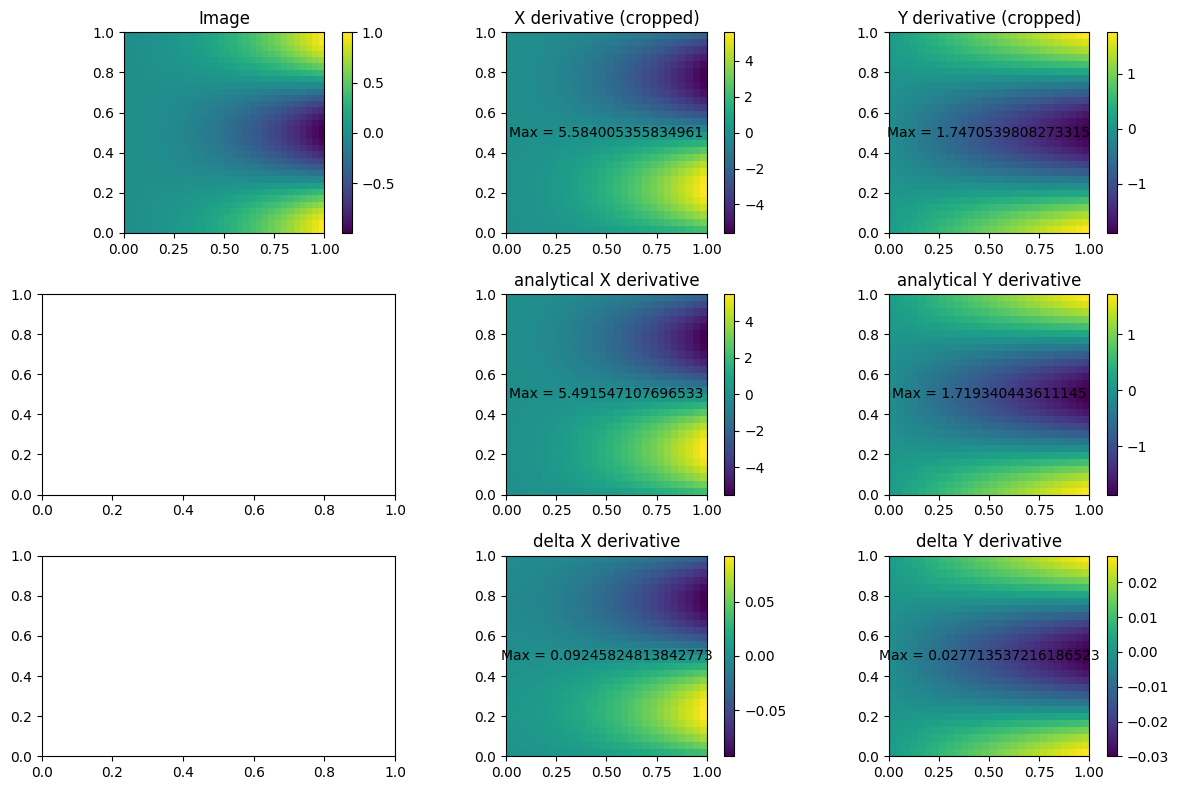

In [ ]:
nx = 32; xmin=0.; xmax=1.0; delta_x = (xmax-xmin)/(nx-1)
xvals = torch.arange(start=xmin, end=xmax+1e-6, step=delta_x)
ny = 32; ymin=0.; ymax=1.0; delta_y = (ymax-ymin)/(ny-1)
yvals = torch.arange(start=ymin, end=ymax+1e-6, step=delta_y)
print('delta_x=',delta_x)
print('delta_y=',delta_y)

# Filter kernels
k = torch.Tensor([0.030320,  0.249724,  0.439911,  0.249724,  0.030320]);
d = torch.Tensor([0.104550,  0.292315,  0.000000, -0.292315, -0.104550]);
gy = torch.outer(k, d)
gx = gy.transpose(0,1)
# print('gx={0}'.format(gx))
# print('gy={0}'.format(gy))
# print('gx*gy={0}'.format(gx*gy))

# Image tensor (random analytical function so we can take its derivatives)
img = torch.outer(torch.cos(2*pi*xvals), torch.pow(yvals, 2))
img = img.reshape(1, 1, nx, ny)
ana_dx = -2*pi*torch.outer(torch.sin(2*pi*xvals), torch.pow(yvals, 2)) # analytical sol
ana_dy =     2*torch.outer(torch.cos(2*pi*xvals), yvals) # analytical sol
ana_dx.reshape(1, 1, nx, ny)
ana_dy.reshape(1, 1, nx, ny)

# Find mutliplying coefficient to get exact derivatives
img_dx0 = -F.conv2d(img, gx.view(1, 1, 5, 5))
img_dy0 = -F.conv2d(img, gy.view(1, 1, 5, 5))
print('img_dy0.shape = {0}, ana_dx.shape = {1}'.format(img_dy0.shape, ana_dx.shape))
print('torch.max(img_dx0)=',torch.max(img_dx0))
print('torch.max(ana_dx cropped) =',torch.max(ana_dx[2:-2, 2:-2]))
real_coeff_x = torch.max(ana_dx[2:-2, 2:-2]) / torch.max(img_dx0)
real_coeff_y = torch.max(ana_dy[2:-2, 2:-2]) / torch.max(img_dy0)
print('Real coeff_x = ', real_coeff_x.item())
print('Real coeff_y = ', real_coeff_y.item())
alpha_x = real_coeff_x * delta_x
alpha_y = real_coeff_y * delta_y
print('Real alpha_x = ', alpha_x.item())
print('Real alpha_y = ', alpha_y.item())

# Using alpha from empirically found law (see "Image_gradient_coeff.xlsx")
if 1:
  alpha_x = (1.13728332519531-0.999171367537028)*np.exp(-0.0961513980519414*(nx-16))+0.999171367537028
  alpha_y = (1.13728332519531-0.999171367537028)*np.exp(-0.0961513980519414*(ny-16))+0.999171367537028
  print('From formula, alpha_x = ', alpha_x.item())
  print('From formula, alpha_y = ', alpha_y.item())
coeff_x = -alpha_x / delta_x
coeff_y = -alpha_y / delta_y
print("coeff_x = {0}, coeff_y = {1}".format(coeff_x, coeff_y))

# Convolve image
img_dx = coeff_x * F.conv2d(img, gx.view(1, 1, 5, 5))
img_dy = coeff_y * F.conv2d(img, gy.view(1, 1, 5, 5))
print('shape img_dx = ', img_dx.shape)

# # Calculate gradient magnitude
# magnitude = torch.sqrt(img_dx**2 + img_dy**2)

# # Calculate gradient orientation
# orientation = torch.atan2(img_dy, img_dx)

# plot
print('Max value of img_dx is {0}'.format(torch.max(img_dx)))
print('Max value of ana_dx (cropped) is {0}'.format(torch.max(ana_dx[2:-2, 2:-2])))
fig, ((ax1, ax2, ax3), (_, ax5, ax6), (_, ax8, ax9)) = plt.subplots(3, 3, figsize=(12, 8))
s1 = ax1.imshow(img[0,0,:,:], extent=[xmin,xmax,ymin,ymax])
fig.colorbar(s1, ax=ax1)
ax1.set_title("Image")

s2 = ax2.imshow(img_dx[0,0,:,:], extent=[xmin,xmax,ymin,ymax])
fig.colorbar(s2, ax=ax2)
ax2.set_title("X derivative (cropped)")
ax2.text(0.5, 0.5, 'Max = {0}'.format(torch.max(img_dx)), ha='center', va='center')

s3 = ax3.imshow(img_dy[0,0,:,:], extent=[xmin,xmax,ymin,ymax])
fig.colorbar(s3, ax=ax3)
ax3.set_title("Y derivative (cropped)")
ax3.text(0.5, 0.5, 'Max = {0}'.format(torch.max(img_dy)), ha='center', va='center')

s5 = ax5.imshow(ana_dx[2:-2,2:-2], extent=[xmin,xmax,ymin,ymax])
fig.colorbar(s5, ax=ax5)
ax5.set_title("analytical X derivative")
ax5.text(0.5, 0.5, 'Max = {0}'.format(torch.max(ana_dx[2:-2,2:-2])), ha='center', va='center')

s6 = ax6.imshow(ana_dy[2:-2,2:-2], extent=[xmin,xmax,ymin,ymax])
fig.colorbar(s6, ax=ax6)
ax6.set_title("analytical Y derivative")
ax6.text(0.5, 0.5, 'Max = {0}'.format(torch.max(ana_dy[2:-2,2:-2])), ha='center', va='center')

s8 = ax8.imshow(img_dx[0,0,:,:] - ana_dx[2:-2,2:-2], extent=[xmin,xmax,ymin,ymax])
fig.colorbar(s8, ax=ax8)
ax8.set_title("delta X derivative")
ax8.text(0.5, 0.5, 'Max = {0}'.format(torch.max(img_dx[0,0,:,:] - ana_dx[2:-2,2:-2])), ha='center', va='center')

s9 = ax9.imshow(img_dy[0,0,:,:] - ana_dy[2:-2,2:-2], extent=[xmin,xmax,ymin,ymax])
fig.colorbar(s9, ax=ax9)
ax9.set_title("delta Y derivative")
ax9.text(0.5, 0.5, 'Max = {0}'.format(torch.max(img_dy[0,0,:,:] - ana_dy[2:-2,2:-2])), ha='center', va='center')

fig.tight_layout()
plt.show()


# Computing image laplacian in PyTorch

## Using a 3x3 filter (not computing derivative on boundary layers)
(https://sbme-tutorials.github.io/2018/cv/notes/4_week4.html#laplacian)
$f(x,y)=cos(2\pi x) sin(2\pi y)$

xvals.shape= torch.Size([64])
yvals.shape= torch.Size([64])
gx=tensor([[0., 1., 0.],
        [1., 4., 1.],
        [0., 1., 0.]])
img_lap0.shape = torch.Size([1, 1, 62, 62]), ana_lap.shape = torch.Size([1, 1, 64, 64])
torch.max(img_lap0)= tensor(7.9677)
torch.max(ana_lap cropped) = tensor(78.8342)
Real coeff =  9.894186973571777
Real alpha =  9.894186973571777
From formula, alpha_x =  9.880939350316519
coeff = -9.880939350316519
shape img_lap =  torch.Size([1, 1, 62, 62])
Max value of img_dx is 6.2670674324035645
Max value of ana_dx (cropped) is 6.2670674324035645


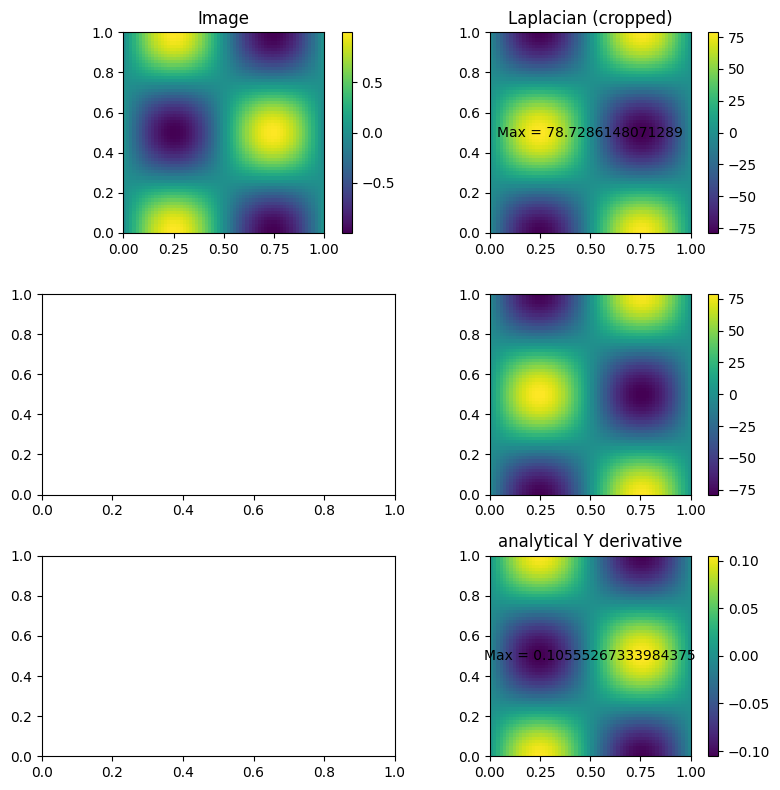

In [91]:
n = 64
nx = n; xmin=0.; xmax=1.0; delta_x = (xmax-xmin)/(nx-1)
xvals = torch.arange(start=xmin, end=xmax+1e-6, step=delta_x)
ny = n; ymin=0.; ymax=1.0; delta_y = (ymax-ymin)/(ny-1)
yvals = torch.arange(start=ymin, end=ymax+1e-6, step=delta_y)
print('xvals.shape=',xvals.shape)
print('yvals.shape=',xvals.shape)

# Filter kernels
g = torch.Tensor([[0., 1., 0.],
                  [1., 4., 1.],
                  [0., 1., 0.]])
print('gx={0}'.format(g))

# Image tensor
img = torch.outer(torch.cos(2*pi*xvals), torch.sin(2*pi*yvals))
img = img.reshape(1, 1, nx, ny)
ana_lap = -8 * pi**2 * img

# Find mutliplying coefficient to get exact derivatives
img_lap0 = -F.conv2d(img, g.view(1, 1, 3, 3))
print('img_lap0.shape = {0}, ana_lap.shape = {1}'.format(img_lap0.shape, ana_lap.shape))
print('torch.max(img_lap0)=',torch.max(img_lap0))
print('torch.max(ana_lap cropped) =',torch.max(ana_lap[0, 0, 1:-1, 1:-1]))
real_coeff = torch.max(ana_lap[0, 0, 1:-1, 1:-1]) / torch.max(img_lap0)
print('Real coeff = ', real_coeff.item())
assert delta_x == delta_y
alpha = real_coeff # * delta_x**0
print('Real alpha = ', alpha.item())

# Using alpha from empirically found law (see "Image_gradient_coeff_3x3.xlsx")
if 1:
  alpha = (10.3155145645141-9.8761338094852)*np.exp(-0.0940749326804537*(nx-16))+9.8761338094852
  print('From formula, alpha_x = ', alpha.item())
coeff = -alpha # / delta_x**0
print("coeff = {0}".format(coeff))

# Convolve image
img_lap = coeff * F.conv2d(img, g.view(1, 1, 3, 3))
print('shape img_lap = ', img_lap.shape)

# plot
if 1:
  print('Max value of img_dx is {0}'.format(torch.max(img_dx)))
  print('Max value of ana_dx (cropped) is {0}'.format(torch.max(ana_dx[1:-1, 1:-1])))
  fig, ((ax1, ax2), (_, ax4), (_, ax6)) = plt.subplots(3, 2, figsize=(8, 8))
  s1 = ax1.imshow(img[0,0,:,:], extent=[xmin,xmax,ymin,ymax])
  fig.colorbar(s1, ax=ax1)
  ax1.set_title("Image")

  s2 = ax2.imshow(img_lap[0,0,:,:], extent=[xmin,xmax,ymin,ymax])
  fig.colorbar(s2, ax=ax2)
  ax2.set_title("Laplacian (cropped)")
  ax2.text(0.5, 0.5, 'Max = {0}'.format(torch.max(img_lap)), ha='center', va='center')

  s4 = ax4.imshow(ana_lap[0,0,1:-1,1:-1], extent=[xmin,xmax,ymin,ymax])
  fig.colorbar(s4, ax=ax4)
  ax5.set_title("analytical laplacian")
  ax5.text(0.5, 0.5, 'Max = {0}'.format(torch.max(ana_lap[0,0,1:-1,1:-1])), ha='center', va='center')

  s6 = ax6.imshow(img_lap[0,0,:,:] - ana_lap[0,0,1:-1,1:-1], extent=[xmin,xmax,ymin,ymax])
  fig.colorbar(s6, ax=ax6)
  ax6.set_title("analytical Y derivative")
  ax6.text(0.5, 0.5, 'Max = {0}'.format(torch.max(img_lap[0,0,:,:] - ana_lap[0,0,1:-1,1:-1])), ha='center', va='center')

  fig.tight_layout()
  plt.show()
